---
date: last-modified
---

# TEMPO UVAI vs DSCOVR (spatial)

## Summary

This notebook illustrates a comparison of ultra-violet aerosol index (UVAI) between the Tropospheric Emissions: Monitoring of Pollution (TEMPO) instrument and DSCOVR EPIC UVAI. TEMPO_O3TOT_L2_V03 and DSCOVR_EPIC_L2_AER_03 are the data collections used as sources of UVAI.

TEMPO and DSCOVR granules are downloaded on-the-fly with [earthaccess](https://earthaccess.readthedocs.io/en/latest/) library, which may need to be installed first.

## Dataset Information

"DSCOVR_EPIC_L2_AER_03 is the Deep Space Climate Observatory (DSCOVR) Enhanced Polychromatic Imaging Camera (EPIC) Level 2 UV Aerosol Version 3 data product. Observations for this data product are at 340 and 388 nm and are used to derive near UV (ultraviolet) aerosol properties. The EPIC aerosol retrieval algorithm (EPICAERUV) uses a set of aerosol models to account for the presence of carbonaceous aerosols from biomass burning and wildfires (BIO), desert dust (DST), and sulfate-based (SLF) aerosols. These aerosol models are identical to those assumed in the OMI (Ozone Monitoring Instrument) algorithm (Torres et al., 2007; Jethva and Torres, 2011)." ([Source](https://asdc.larc.nasa.gov/project/DSCOVR/DSCOVR_EPIC_L2_AER_03))

Total ozone Level 2 files provide ozone information at Tropospheric Emissions: Monitoring of Pollution (TEMPO)’s native spatial resolution, ~10 km^2 at the center of the Field of Regard (FOR), for individual granules. Each granule covers the entire North-South TEMPO FOR but only a portion of the East-West FOR.

## Descriptive outline:

- A timeframe of interest is selected by a user.
- Data from DSCOVR EPIC are found within the TEMPO field of regard (FOR) and within user's timeframe using the `earthaccess` library.
- After downloading DSCOVR EPIC granules, a loop of these granules searches for TEMPO granules simultaneous with DSCOVR EPIC one.
- If coincident TEMPO granules exist, DSCOVR EPIC UVAI retrievals are interpolated to the positions of the TEMPO pixels.
- Interpolated values are written into a netCDF file along with TEMPO geolocations.
- Finally, original UVAI data from DSCOVR EPIC and TEMPO are plotted along with interpolated DSCOVR EPIC values in the same plot. Output images are written into PNG files.

## Prerequisites

A free(!) account at https://www.earthdata.nasa.gov/ is needed to login and download the appropriate files.

This notebook was last tested using Python 3.10.15, and requires these libraries:

- [cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/)
- [h5py]
- [matplotlib](http://matplotlib.org/)
- [netCDF4](https://github.com/Unidata/netcdf4-python)
- [numpy](https://numpy.org/)
- [shapely]
- [scipy]

### Notebook Author / Affiliation
Alexander Radkevich / Atmospheric Science Data Center

# 1. Setup

In [1]:
from datetime import datetime, timedelta  # needed to work with time in plotting time series

import cartopy.crs as ccrs
import earthaccess  # needed to discover and download TEMPO data
import h5py  # needed to read DSCOVR_EPIC_L2_TO3 files
import matplotlib.pyplot as plt  # needed to plot the resulting time series
import netCDF4 as nc  # needed to read TEMPO data
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point, Polygon  # needed to search a point within a polygon
from scipy.interpolate import griddata  # needed to interpolate TEMPO data to the point of interest

# 2. Define utility functions for DSCOVR and TEMPO data

## 2.1 Function to read DSCOVR AER data files

Function `read_epic_l2_AER` reads a DSCOVR_EPIC_L2_AER product file given by its filename
and returns arrays of 2D latitudes, longitudes, UVAI, AOD, and wavelength,
along with their fill values and time.

In [2]:
def get_dataset_array_and_fill_value(file_object: h5py.File, dataset_path: str):
    h5_dataset = file_object[dataset_path]
    return np.array(h5_dataset[:]), h5_dataset.fillvalue


def read_epic_l2_AER(filename: str):
    aod_name = "/HDFEOS/SWATHS/Aerosol NearUV Swath/Data Fields/FinalAerosolOpticalDepth"
    uvai_name = "/HDFEOS/SWATHS/Aerosol NearUV Swath/Data Fields/UVAerosolIndex"
    lat_name = "/HDFEOS/SWATHS/Aerosol NearUV Swath/Geolocation Fields/Latitude"
    lon_name = "/HDFEOS/SWATHS/Aerosol NearUV Swath/Geolocation Fields/Longitude"
    wl_name = "/HDFEOS/SWATHS/Aerosol NearUV Swath/Data Fields/Wavelength"

    arrays = {}
    fill_values = {}

    with h5py.File(filename, "r") as f:
        arrays["aod2D"], fill_values["aod"] = get_dataset_array_and_fill_value(f, aod_name)
        arrays["uvai2D"], fill_values["uvai"] = get_dataset_array_and_fill_value(f, uvai_name)
        arrays["lat2D"], fill_values["lat"] = get_dataset_array_and_fill_value(f, lat_name)
        arrays["lon2D"], fill_values["lon"] = get_dataset_array_and_fill_value(f, lon_name)
        arrays["wl"], fill_values["wl"] = get_dataset_array_and_fill_value(f, wl_name)

    # Get time from the granule's filename.
    timestamp = datetime.strptime(filename.split("_")[-2], "%Y%m%d%H%M%S")

    return arrays, fill_values, timestamp

## 2.2 Function to read UV Aerosol Index from TEMPO O3TOT data file

In [3]:
def read_TEMPO_O3TOT_L2_UVAI(filename):
    """Read the following product arrays from the TEMPO_O3TOT_L2_V01(2):
        - vertical_column
        - vertical_column_uncertainty

    and returns the respective fields along with coordinates of the pixels.
    """
    var_name = "uv_aerosol_index"
    var_QF_name = "quality_flag"

    arrays = {}
    fill_values = {}

    with nc.Dataset(filename) as ds:
        # Open the product group (/product), read the chosen UVAI variable and its quality flag.
        prod = ds.groups["product"]
        arrays["uvai"] = prod.variables[var_name][:]
        fill_values["uvai"] = prod.variables[var_name].getncattr("_FillValue")
        var_QF = prod.variables[var_QF_name]
        arrays["uvai_QF"] = var_QF[:]
        # Note: there is no fill value for the quality flag.
        # Once it is available in the next version of the product,
        # uncomment the line below and add fv_QF to the return line.
        #    fv_QF = var_QF.getncattr('_FillValue'

        # Open geolocation group (/geolocation), and
        #   read the latitude and longitude variables into a numpy array.
        geo = ds.groups["geolocation"]
        arrays["lat"] = geo.variables["latitude"][:]
        arrays["lon"] = geo.variables["longitude"][:]
        fill_values["geo"] = geo.variables["latitude"].getncattr("_FillValue")
        # Note: it appeared that garbage values of latitudes and longitudes in the L2 files
        # are 9.969209968386869E36 while fill value is -1.2676506E30
        # (after deeper search, it was found that the actual value in the file is -1.2676506002282294E30).
        # For this reason, fv_geo is set to 9.96921E36 to make the code working.
        # Once the problem is resolved and garbage values of latitudes and longitudes
        # equal to their fill value, the line below must be removed.
        fill_values["geo"] = 9.969209968386869e3

        # Read the time variable from the geolocation group into a numpy array.
        arrays["time"] = geo.variables["time"][:]

    return arrays, fill_values

## 2.3 Function to create TEMPO O3 granule polygon

In [4]:
def TEMPO_L2_polygon(lat, lon, geo_fillvalue):
    nx, ny = lon.shape
    print(f"granule has {nx: >3} scanlines by {ny: >4} pixels")
    dpos = np.empty([0, 2])

    # Create arrays for x and y indices.
    x_indices = np.arange(nx).reshape(-1, 1)
    y_indices = np.arange(ny).reshape(1, -1)
    x_index_array = np.repeat(x_indices, ny, axis=1)
    y_index_array = np.repeat(y_indices, nx, axis=0)

    mask = (lon[nx - 1, ny - 1] != geo_fillvalue) & (lat[nx - 1, ny - 1] != geo_fillvalue)
    if len(lon[mask]) == 0:
        print("the granule is empty - no meaningful positions")
        return dpos

    def get_local_mask(row_index):
        return (lon[row_index, :] != geo_fillvalue) & (lat[row_index, :] != geo_fillvalue)

    # Right boundary.
    right_min_index = np.min(x_index_array[mask])
    local_mask = get_local_mask(right_min_index)
    right_boundary = np.stack(
        (lon[right_min_index, local_mask], lat[right_min_index, local_mask])
    ).T

    # Left boundary.
    left_max_index = np.max(x_index_array[mask])
    local_mask = get_local_mask(left_max_index)
    left_boundary = np.stack((lon[left_max_index, local_mask], lat[left_max_index, local_mask])).T

    # Top and bottom boundaries.
    top_boundary = np.empty([0, 2])
    bot_boundary = np.empty([0, 2])
    for ix in range(right_min_index + 1, left_max_index):
        local_mask = get_local_mask(ix)
        local_y_ind = y_index_array[ix, local_mask]
        y_ind_top = min(local_y_ind)
        y_ind_bottom = max(local_y_ind)
        top_boundary = np.append(top_boundary, [[lon[ix, y_ind_top], lat[ix, y_ind_top]]], axis=0)
        bot_boundary = np.append(
            bot_boundary, [[lon[ix, y_ind_bottom], lat[ix, y_ind_bottom]]], axis=0
        )

    # Combine right, top, left, and bottom boundaries, going along the combined boundary counterclockwise.
    dpos = np.append(dpos, right_boundary[::-1, :], axis=0)
    dpos = np.append(dpos, top_boundary, axis=0)
    dpos = np.append(dpos, left_boundary, axis=0)
    dpos = np.append(dpos, bot_boundary[::-1, :], axis=0)

    print("polygon shape: ", dpos.shape)

    coords_poly = list(dpos)
    poly = Polygon(coords_poly)

    return poly

## 2.4 Function to write DSCOVR EPIC UV Aerosol Index re-mapped to TEMPO granule locations

In [5]:
def write_DSCOVR_TEMPO_UVAI(filename, lat2D, lon2D, uvai2D):
    """Create a netCDF file. Return True if successful, otherwise return False.

    variables:
        filename: TEMPO file name, which will be used to create output file name
        lat2D: 2D array of TEMPO latitudes
        lon2D: 2D array of TEMPO longitudes
        uvai2D: 2D array of DSCOVR EPIC UVAI re-mapped to TEMPO locations

    Arrays above should be of the same shape.
    """
    (nx, ny) = lat2D.shape

    with nc.Dataset("DSCOVR_UVAI_" + filename, mode="w", format="NETCDF4_CLASSIC") as ncf:
        _ = ncf.createDimension("mirror_step", nx)  # number of scanlines
        _ = ncf.createDimension("xtrack", ny)  # number of pixels in a scanline

        lat = ncf.createVariable("lat", np.float32, ("mirror_step", "xtrack"))
        lat.units = "degrees_north"
        lat.long_name = "latitude"
        lat[:, :] = lat2D

        lon = ncf.createVariable("lon", np.float32, ("mirror_step", "xtrack"))
        lon.units = "degrees_east"
        lon.long_name = "longitude"
        lon[:, :] = lon2D

        uv_aerosol_index = ncf.createVariable(
            "uv_aerosol_index", np.float32, ("mirror_step", "xtrack")
        )
        uv_aerosol_index[:, :] = uvai2D

## 2.5 Function to find TEMPO granules that match time of DSCOVR granule

In [6]:
# Setting TEMPO name constants
tempo_short_name = "TEMPO_O3TOT_L2"  # collection name to search for in the EarthData
tempo_version = "V03"  # this is the latest available version as of August 02, 2024


def get_TEMPO_results_to_match_DSCOVR_granule(dscovr_timestamp):
    """Return results for TEMPO. If none found, return None.

    It was discovered that the actual timespan of an EPIC granule begins 289 s before
    the granule timestamp and ends 107 s after it.
    This timeframe will be used for searching TEMPO granules.
    """
    timestamp1 = dscovr_timestamp + timedelta(seconds=-289)
    timestamp2 = dscovr_timestamp + timedelta(seconds=107)
    print(dscovr_timestamp, timestamp1, timestamp2)

    # Try twice.
    for attempt in range(2):
        try:
            results = earthaccess.search_data(
                short_name=tempo_short_name,
                version=tempo_version,
                temporal=(timestamp1, timestamp2),
            )

            if len(results) > 0:
                print(
                    f"Total number of TEMPO version {tempo_version} granules found"
                    f"\nwithin period of interest between {timestamp1} and {timestamp2}"
                    f" is {len(results)}"
                )
                return results
            else:
                break

        except Exception:
            continue

    print(
        f"Zero TEMPO version {tempo_version} granules found"
        f"\nwithin period of interest between {timestamp1} and {timestamp2}"
    )
    return None

## 2.6 Function to find 'good' TEMPO data points

In [7]:
def get_good_tempo_points(lat, lon, geo_fillvalue, uvai, uvai_fillvalue):
    # Mask out fill values of TEMPO lat/lon positions.
    mask = (lat != geo_fillvalue) & (lon != geo_fillvalue) & (uvai != uvai_fillvalue)
    lon1D = lon[mask]
    lat1D = lat[mask]
    lonlat_stacked = np.column_stack((lon1D, lat1D))
    uvai1D = uvai[mask]
    extent = (min(lon1D), max(lon1D), min(lat1D), max(lat1D))

    # Create arrays of indices to restore TEMPO 2D arrays after re-mapping.
    nx, ny = lat.shape
    y_index_array = np.tile(np.linspace(0, ny, ny, endpoint=False, dtype=int), (nx, 1))
    x_index_array = np.tile(np.linspace(0, nx, nx, endpoint=False, dtype=int), (ny, 1)).transpose()
    x_indices_masked = x_index_array[mask]
    y_indices_masked = y_index_array[mask]
    print(f"nx, ny = {nx}, {ny}")

    # Restore 2D arrays by filling over a fill value.
    lat2D = np.full((nx, ny), -999.0)
    lon2D = np.full((nx, ny), -999.0)
    uvai2D = np.full((nx, ny), -999.0)

    for ix, iy, lon1, lat1, uvai1 in zip(x_indices_masked, y_indices_masked, lon1D, lat1D, uvai1D):
        lat2D[ix, iy] = lat1
        lon2D[ix, iy] = lon1
        uvai2D[ix, iy] = uvai1

    # Write restored 2D arrays to a netCDF file.
    try:
        write_DSCOVR_TEMPO_UVAI(tempo_file_name, lat2D, lon2D, uvai2D)
    except Exception:
        print("failed to write restored TEMPO 2D arrays into the output file")

    return lonlat_stacked, extent, lon1D, lat1D, uvai1D

## 2.7 Function to determine DSCOVR data points within the domain of TEMPO data

In [8]:
def mask_dscovr_to_tempo(
    lat2D, lon2D, uvai2D, uvai_fillvalue, tempo_extent, tempo_polygon
) -> dict | None:
    # Mask out DSCOVR UVAI to the geospatial extent of TEMPO granule.
    mask = (
        (uvai2D != uvai_fillvalue)
        & (lat2D > tempo_extent[2])
        & (lat2D < tempo_extent[3])
        & (lon2D > tempo_extent[0])
        & (lon2D < tempo_extent[1])
    )
    lon1D = lon2D[mask]
    lat1D = lat2D[mask]
    uvai1D = uvai2D[mask]

    # Number of DSCOVR pixels falling into ranges min_TEMPO_lat < lat2D < max_TEMPO_lat, min_TEMPO_lon < lat2D < max_TEMPO_lon.
    n_DSCOVR_TEMPO = len(uvai1D)
    if n_DSCOVR_TEMPO == 0:
        print("no original DSCOVR pixels within TEMPO granule")
        return None

    mask_DSCOVR_in_TEMPO = np.empty(n_DSCOVR_TEMPO, dtype=np.bool_)
    for i in range(n_DSCOVR_TEMPO):
        dscovr_point = Point(np.array([lon1D[i], lat1D[i]]))
        mask_DSCOVR_in_TEMPO[i] = dscovr_point.within(tempo_polygon)

    lon1D_DSCOVR_TEMPO = lon1D[mask_DSCOVR_in_TEMPO]
    lat1D_DSCOVR_TEMPO = lat1D[mask_DSCOVR_in_TEMPO]
    uvai1D_DSCOVR_TEMPO = uvai1D[mask_DSCOVR_in_TEMPO]

    return {
        "lon1D": lon1D_DSCOVR_TEMPO,
        "lat1D": lat1D_DSCOVR_TEMPO,
        "uvai1D": uvai1D_DSCOVR_TEMPO,
        "mask": mask_DSCOVR_in_TEMPO,
    }

# 3. Establish access to EarthData - Log in

Function `earthaccess.login` prompts for EarthData login and password.

In [9]:
auth = earthaccess.login(strategy="interactive", persist=True)

# 4. Select timeframe of interest

DSCOVR EPIC granules will be searched within this timeframe.

For the tutorial demonstration, `20230805` was used for both the start and end date.

In [10]:
print("enter period of interest, start and end dates, in the form YYYYMMDD")
datestamp_initial = input("enter start date of interest ")
datestamp_final = input("enter end date of interest ")

date_start = datetime.strptime(datestamp_initial + "00:00:00", "%Y%m%d%H:%M:%S").strftime(
    "%Y-%m-%d %H:%M:%S"
)
date_end = datetime.strptime(datestamp_final + "23:59:59", "%Y%m%d%H:%M:%S").strftime(
    "%Y-%m-%d %H:%M:%S"
)

print(date_start, date_end)

enter period of interest, start and end dates, in the form YYYYMMDD


enter start date of interest  20230805
enter end date of interest  20230805


2023-08-05 00:00:00 2023-08-05 23:59:59


enter start date of interest  20230805
enter end date of interest  20230805


2023 8 5 2023 8 5


# 5. Retrieve DSCOVR EPIC granules

We search for DSCOVR EPIC granules that fall within the time of interest and within the TEMPO Field of Regard (FOR) polygon.

In [11]:
short_name = "DSCOVR_EPIC_L2_AER"  # collection name to search for in the EarthData

# The polygon below is taken from MMT description of TEMPO_O3TOT_L2,
# see https://mmt.earthdata.nasa.gov/collections/C2842849465-LARC_CLOUD
# Polygon: (10.0°, -170.0°), (10.0°, -10.0°), (80.0°, -10.0°), (80.0°, -170.0°), (10.0°, -170.0°)

bbox = (-170.0, 10.0, -10.0, 80.0)

FOR_results_EPIC = earthaccess.search_data(
    short_name=short_name, temporal=(date_start, date_end), bounding_box=bbox
)

print(
    f"Total number of DSCOVR EPIC L2_AER granules found for TEMPO Field of Regard"
    f"\nwithin period of interest between {date_start} and {date_end} is {len(FOR_results_EPIC)}"
)

Total number of DSCOVR EPIC L2_AER granules found for TEMPO Field of Regard
within period of interest between 2023-08-05 00:00:00 and 2023-08-05 23:59:59 is 21


## 5.1. Ensure all discovered granules have download links

Without this step, missing granules can crash the call of `earthaccess.download()`.

In [12]:
def get_url_value_from_result(earthaccess_result):
    """Return a tuple of the result itself and the data URL, only if the URL field is accessible."""
    try:
        return earthaccess_result, earthaccess_result["umm"]["RelatedUrls"][0]["URL"]
    except Exception:
        return None


# Populate the list of results that have links.
good_EPIC_result_links = [
    get_url_value_from_result(result)
    for result in FOR_results_EPIC
    if get_url_value_from_result(result) is not None
]

# Show the result links
for r in sorted(good_EPIC_result_links, key=lambda x: x[1]):
    print(r[1])

https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_AER_03/2023/08/DSCOVR_EPIC_L2_AER_03_20230805004554_03.he5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_AER_03/2023/08/DSCOVR_EPIC_L2_AER_03_20230805015122_03.he5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_AER_03/2023/08/DSCOVR_EPIC_L2_AER_03_20230805025649_03.he5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_AER_03/2023/08/DSCOVR_EPIC_L2_AER_03_20230805040216_03.he5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_AER_03/2023/08/DSCOVR_EPIC_L2_AER_03_20230805050743_03.he5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_AER_03/2023/08/DSCOVR_EPIC_L2_AER_03_20230805071838_03.he5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_AER_03/2023/08/DSCOVR_EPIC_L2_AER_03_20230805082405_03.he5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_AER_03/2023/08/DSCOVR_EPIC_L2_AER_03_20230805092932_03.he5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2_AER_03/2023/08/DSCOVR_EPIC_L2_AER_03_20230805103500_03.he5
https://asdc.larc.nasa.gov/data/DSCOVR/EPIC/L2

## 5.2. Download DSCOVR EPIC granules

This next cell will likely take awhile.

In [13]:
downloaded_files = earthaccess.download(FOR_results_EPIC, local_path=".")

QUEUEING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/21 [00:00<?, ?it/s]

# 6. For every DSCOVR EPIC granule, find simultaneous TEMPO granules and re-map DSCOVR EPIC data to geolocations of TEMPO


**Cycle through the DSCOVR EPIC granules.**

Write re-mapped DSCOVR EPIC UVAI to a netCDF file,
and plot the original DSCOVR EPIC and TEMPO along with re-mapped DSCOVR EPIC UVAI.

This next cell takes a long time to run.

In [14]:
for epic_granule_link in sorted(good_EPIC_result_links, key=lambda x: x[1]):
    dscovr_file_name = epic_granule_link[1][epic_granule_link[1].rfind("/") + 1 :]
    print(dscovr_file_name)

    # Read the EPIC Level-2 Aerosol data.
    try:
        dscovr, dscovr_fv, dscovr_timestamp = read_epic_l2_AER(dscovr_file_name)
    except Exception:
        print(f"Unable to find or read hdf5 input granule file {dscovr_file_name}")
        continue

    # Search for and download TEMPO data that align with the times of the DSCOVR granule.
    tempo_results = get_TEMPO_results_to_match_DSCOVR_granule(dscovr_timestamp)
    if tempo_results is None:
        continue  # if no TEMPO granules found within the DSCOVR EPIC timeframe, go to the next EPIC granule
    else:
        downloaded_files = earthaccess.download(tempo_results, local_path=".")

    # Generate mask from DSCOVR fill values.
    mask = (
        (dscovr["lat2D"] != dscovr_fv["lat"])
        & (dscovr["lon2D"] != dscovr_fv["lon"])
        & (dscovr["uvai2D"] != dscovr_fv["uvai"])
    )
    dscovr_good_latlon = np.column_stack((dscovr["lon2D"][mask], dscovr["lat2D"][mask]))
    dscovr_good_uvai2D = dscovr["uvai2D"][mask]

    for tempo_result in tempo_results:
        tempo_granule_links = tempo_result.data_links()
        tempo_file_name = tempo_granule_links[0][tempo_granule_links[0].rfind("/") + 1 :]

        # Read the TEMPO data.
        try:
            tempo, tempo_fv = read_TEMPO_O3TOT_L2_UVAI(tempo_file_name)
        except Exception:
            print(f"TEMPO UVAI cannot be read in file {tempo_file_name}")
            continue

        # Generate a polygon representing the boundaries of the TEMPO data.
        tempo_polygon = TEMPO_L2_polygon(tempo["lat"], tempo["lon"], tempo_fv["geo"])

        # Get positions from TEMPO
        tempo_good_lonlat, tempo_extent, lon1D_TEMPO, lat1D_TEMPO, uvai1D_TEMPO = (
            get_good_tempo_points(
                tempo["lat"], tempo["lon"], tempo_fv["geo"], tempo["uvai"], tempo_fv["uvai"]
            )
        )

        # Interpolate DSCOVR data to the TEMPO data locations.
        DSCOVR_uvai_at_tempo_points = griddata(
            dscovr_good_latlon,
            dscovr_good_uvai2D,
            tempo_good_lonlat,
            method="linear",
            fill_value=-999.0,
            rescale=False,
        )

        # Determine where the interpolated values fall within the valid range.
        valid_mask = (DSCOVR_uvai_at_tempo_points > -30) & (DSCOVR_uvai_at_tempo_points < 30)
        if len(DSCOVR_uvai_at_tempo_points[valid_mask]) == 0:
            print("no re-mapped DSCOVR pixels within TEMPO granule")
            continue
        tempo_valid_lon = tempo_good_lonlat[valid_mask, 0]
        tempo_valid_lat = tempo_good_lonlat[valid_mask, 1]
        DSCOVR_uvai_at_tempo_points_valid = DSCOVR_uvai_at_tempo_points[valid_mask]

        # Find where DSCOVR data fall within the boundaries of the TEMPO data.
        dscovr_in_tempo_polygon = mask_dscovr_to_tempo(
            dscovr["lat2D"],
            dscovr["lon2D"],
            dscovr["uvai2D"],
            dscovr_fv["uvai"],
            tempo_extent,
            tempo_polygon,
        )
        if dscovr_in_tempo_polygon is None:
            continue  # if no original DSCOVR pixels within TEMPO granule, then go to the next EPIC granule

        # Plot comparisons of TEMPO and DSCOVR EPIC UVAI
        proj = ccrs.LambertConformal(
            central_longitude=(tempo_extent[0] + tempo_extent[1]) * 0.5,  # -96.0
            central_latitude=39.0,
            false_easting=0.0,
            false_northing=0.0,
            standard_parallels=(33, 45),
            globe=None,
            cutoff=10,
        )
        transform = ccrs.PlateCarree()

        fig, axes = plt.subplots(
            1, 3, figsize=(20, 9), dpi=300, facecolor=None, subplot_kw={"projection": proj}
        )

        for ax in axes:
            ax.set_extent(tempo_extent, crs=transform)
            ax.coastlines(resolution="50m", color="black", linewidth=1)
            grid = ax.gridlines(draw_labels=True, dms=True)
            grid.xformatter = LONGITUDE_FORMATTER
            grid.yformatter = LATITUDE_FORMATTER

        plot_kwargs = dict(s=1, cmap="jet", vmin=-4.0, vmax=4.0, transform=transform)

        # Axis 1
        im = axes[0].scatter(
            dscovr_in_tempo_polygon["lon1D"],
            dscovr_in_tempo_polygon["lat1D"],
            c=dscovr_in_tempo_polygon["uvai1D"],
            **plot_kwargs,
        )
        cb = plt.colorbar(im, ticks=[-4, -2, 0, 2, 4], fraction=0.022, pad=0.01)
        cb.set_label("UVAI", fontsize=10)
        axes[0].set_title("UVAI " + dscovr_file_name, size=10)

        # Axis 2
        im = axes[1].scatter(lon1D_TEMPO, lat1D_TEMPO, c=uvai1D_TEMPO, **plot_kwargs)
        cb = plt.colorbar(im, ticks=[-4, -2, 0, 2, 4], fraction=0.022, pad=0.01)
        cb.set_label("UVAI", fontsize=10)
        axes[1].set_title("UVAI " + tempo_file_name, size=10)

        # Axis 3
        im = axes[2].scatter(
            tempo_valid_lon, tempo_valid_lat, c=DSCOVR_uvai_at_tempo_points_valid, **plot_kwargs
        )
        cb = plt.colorbar(im, ticks=[-4, -2, 0, 2, 4], fraction=0.022, pad=0.01)
        cb.set_label("UVAI", fontsize=10)
        axes[2].set_title("DSCOVR EPIC UVAI re-mapped", size=10)

        plt.savefig("UVAI_" + tempo_file_name + ".png", dpi=300)
        plt.close()

DSCOVR_EPIC_L2_AER_03_20230805004554_03.he5
2023-08-05 00:45:54 2023-08-05 00:41:05 2023-08-05 00:47:41
Zero TEMPO version V03 granules found
within period of interest between 2023-08-05 00:41:05 and 2023-08-05 00:47:41
DSCOVR_EPIC_L2_AER_03_20230805015122_03.he5
2023-08-05 01:51:22 2023-08-05 01:46:33 2023-08-05 01:53:09
Zero TEMPO version V03 granules found
within period of interest between 2023-08-05 01:46:33 and 2023-08-05 01:53:09
DSCOVR_EPIC_L2_AER_03_20230805025649_03.he5
2023-08-05 02:56:49 2023-08-05 02:52:00 2023-08-05 02:58:36
Zero TEMPO version V03 granules found
within period of interest between 2023-08-05 02:52:00 and 2023-08-05 02:58:36
DSCOVR_EPIC_L2_AER_03_20230805040216_03.he5
2023-08-05 04:02:16 2023-08-05 03:57:27 2023-08-05 04:04:03
Zero TEMPO version V03 granules found
within period of interest between 2023-08-05 03:57:27 and 2023-08-05 04:04:03
DSCOVR_EPIC_L2_AER_03_20230805050743_03.he5
2023-08-05 05:07:43 2023-08-05 05:02:54 2023-08-05 05:09:30
Zero TEMPO versi

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805135123_03.he5
2023-08-05 13:51:23 2023-08-05 13:46:34 2023-08-05 13:53:10
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 13:46:34 and 2023-08-05 13:53:10 is 2


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805145650_03.he5
2023-08-05 14:56:50 2023-08-05 14:52:01 2023-08-05 14:58:37
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 14:52:01 and 2023-08-05 14:58:37 is 2


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805160217_03.he5
2023-08-05 16:02:17 2023-08-05 15:57:28 2023-08-05 16:04:04
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 15:57:28 and 2023-08-05 16:04:04 is 2


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805170745_03.he5
2023-08-05 17:07:45 2023-08-05 17:02:56 2023-08-05 17:09:32
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 17:02:56 and 2023-08-05 17:09:32 is 2


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805181312_03.he5
2023-08-05 18:13:12 2023-08-05 18:08:23 2023-08-05 18:14:59
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 18:08:23 and 2023-08-05 18:14:59 is 3


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805191839_03.he5
2023-08-05 19:18:39 2023-08-05 19:13:50 2023-08-05 19:20:26
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 19:13:50 and 2023-08-05 19:20:26 is 2


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805202406_03.he5
2023-08-05 20:24:06 2023-08-05 20:19:17 2023-08-05 20:25:53
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 20:19:17 and 2023-08-05 20:25:53 is 3


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)


/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:5711: UserWarning: Warning: converting a masked element to nan.
  return concatenate((arr, values), axis=axis)


nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:24: UserWarning: Warning: converting a masked element to nan.
  lat2D[ix, iy] = lat1
/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:25: UserWarning: Warning: converting a masked element to nan.
  lon2D[ix, iy] = lon1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805212934_03.he5
2023-08-05 21:29:34 2023-08-05 21:24:45 2023-08-05 21:31:21
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 21:24:45 and 2023-08-05 21:31:21 is 2


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)


/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:5711: UserWarning: Warning: converting a masked element to nan.
  return concatenate((arr, values), axis=axis)


nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:24: UserWarning: Warning: converting a masked element to nan.
  lat2D[ix, iy] = lat1
/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:25: UserWarning: Warning: converting a masked element to nan.
  lon2D[ix, iy] = lon1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805223501_03.he5
2023-08-05 22:35:01 2023-08-05 22:30:12 2023-08-05 22:36:48
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 22:30:12 and 2023-08-05 22:36:48 is 2


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)
nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)


/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:5711: UserWarning: Warning: converting a masked element to nan.
  return concatenate((arr, values), axis=axis)


nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:24: UserWarning: Warning: converting a masked element to nan.
  lat2D[ix, iy] = lat1
/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:25: UserWarning: Warning: converting a masked element to nan.
  lon2D[ix, iy] = lon1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


DSCOVR_EPIC_L2_AER_03_20230805234028_03.he5
2023-08-05 23:40:28 2023-08-05 23:35:39 2023-08-05 23:42:15
Total number of TEMPO version V03 granules found
within period of interest between 2023-08-05 23:35:39 and 2023-08-05 23:42:15 is 1


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

granule has 123 scanlines by 2048 pixels
polygon shape:  (4338, 2)


/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:5711: UserWarning: Warning: converting a masked element to nan.
  return concatenate((arr, values), axis=axis)


nx, ny = 123, 2048


/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:26: UserWarning: Warning: converting a masked element to nan.
  uvai2D[ix, iy] = uvai1
/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:24: UserWarning: Warning: converting a masked element to nan.
  lat2D[ix, iy] = lat1
/var/folders/m6/n4zwmdm91l52f9d9_sj49zy00000gp/T/ipykernel_22277/3761221750.py:25: UserWarning: Warning: converting a masked element to nan.
  lon2D[ix, iy] = lon1
/opt/homebrew/Caskroom/miniconda/base/envs/asdc-github-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


An example output image from running the above:

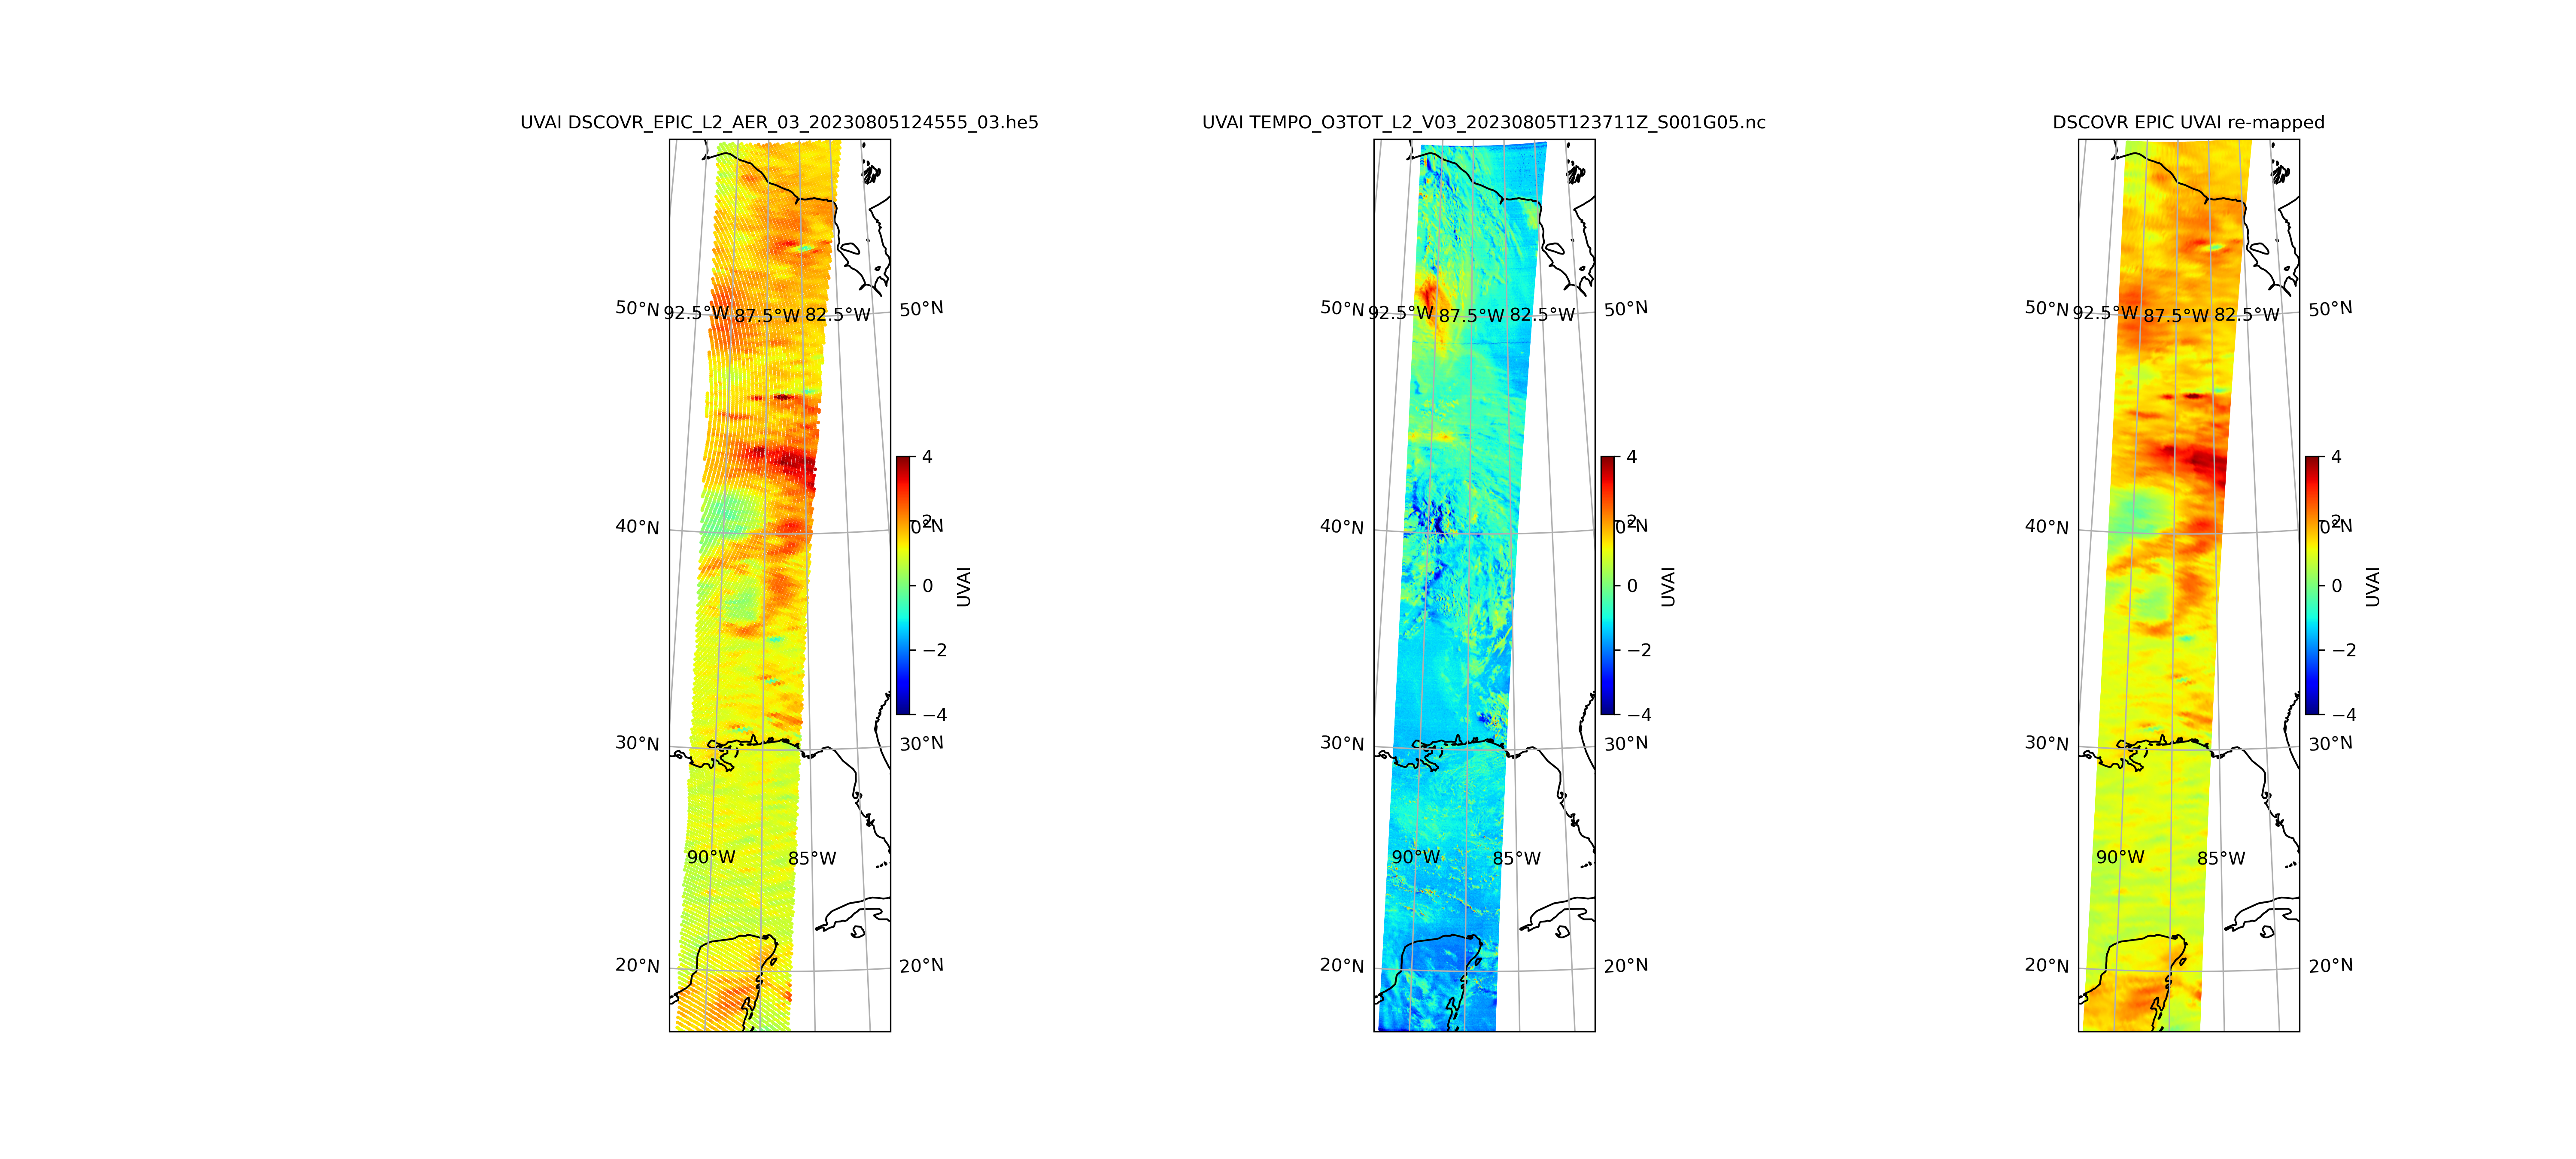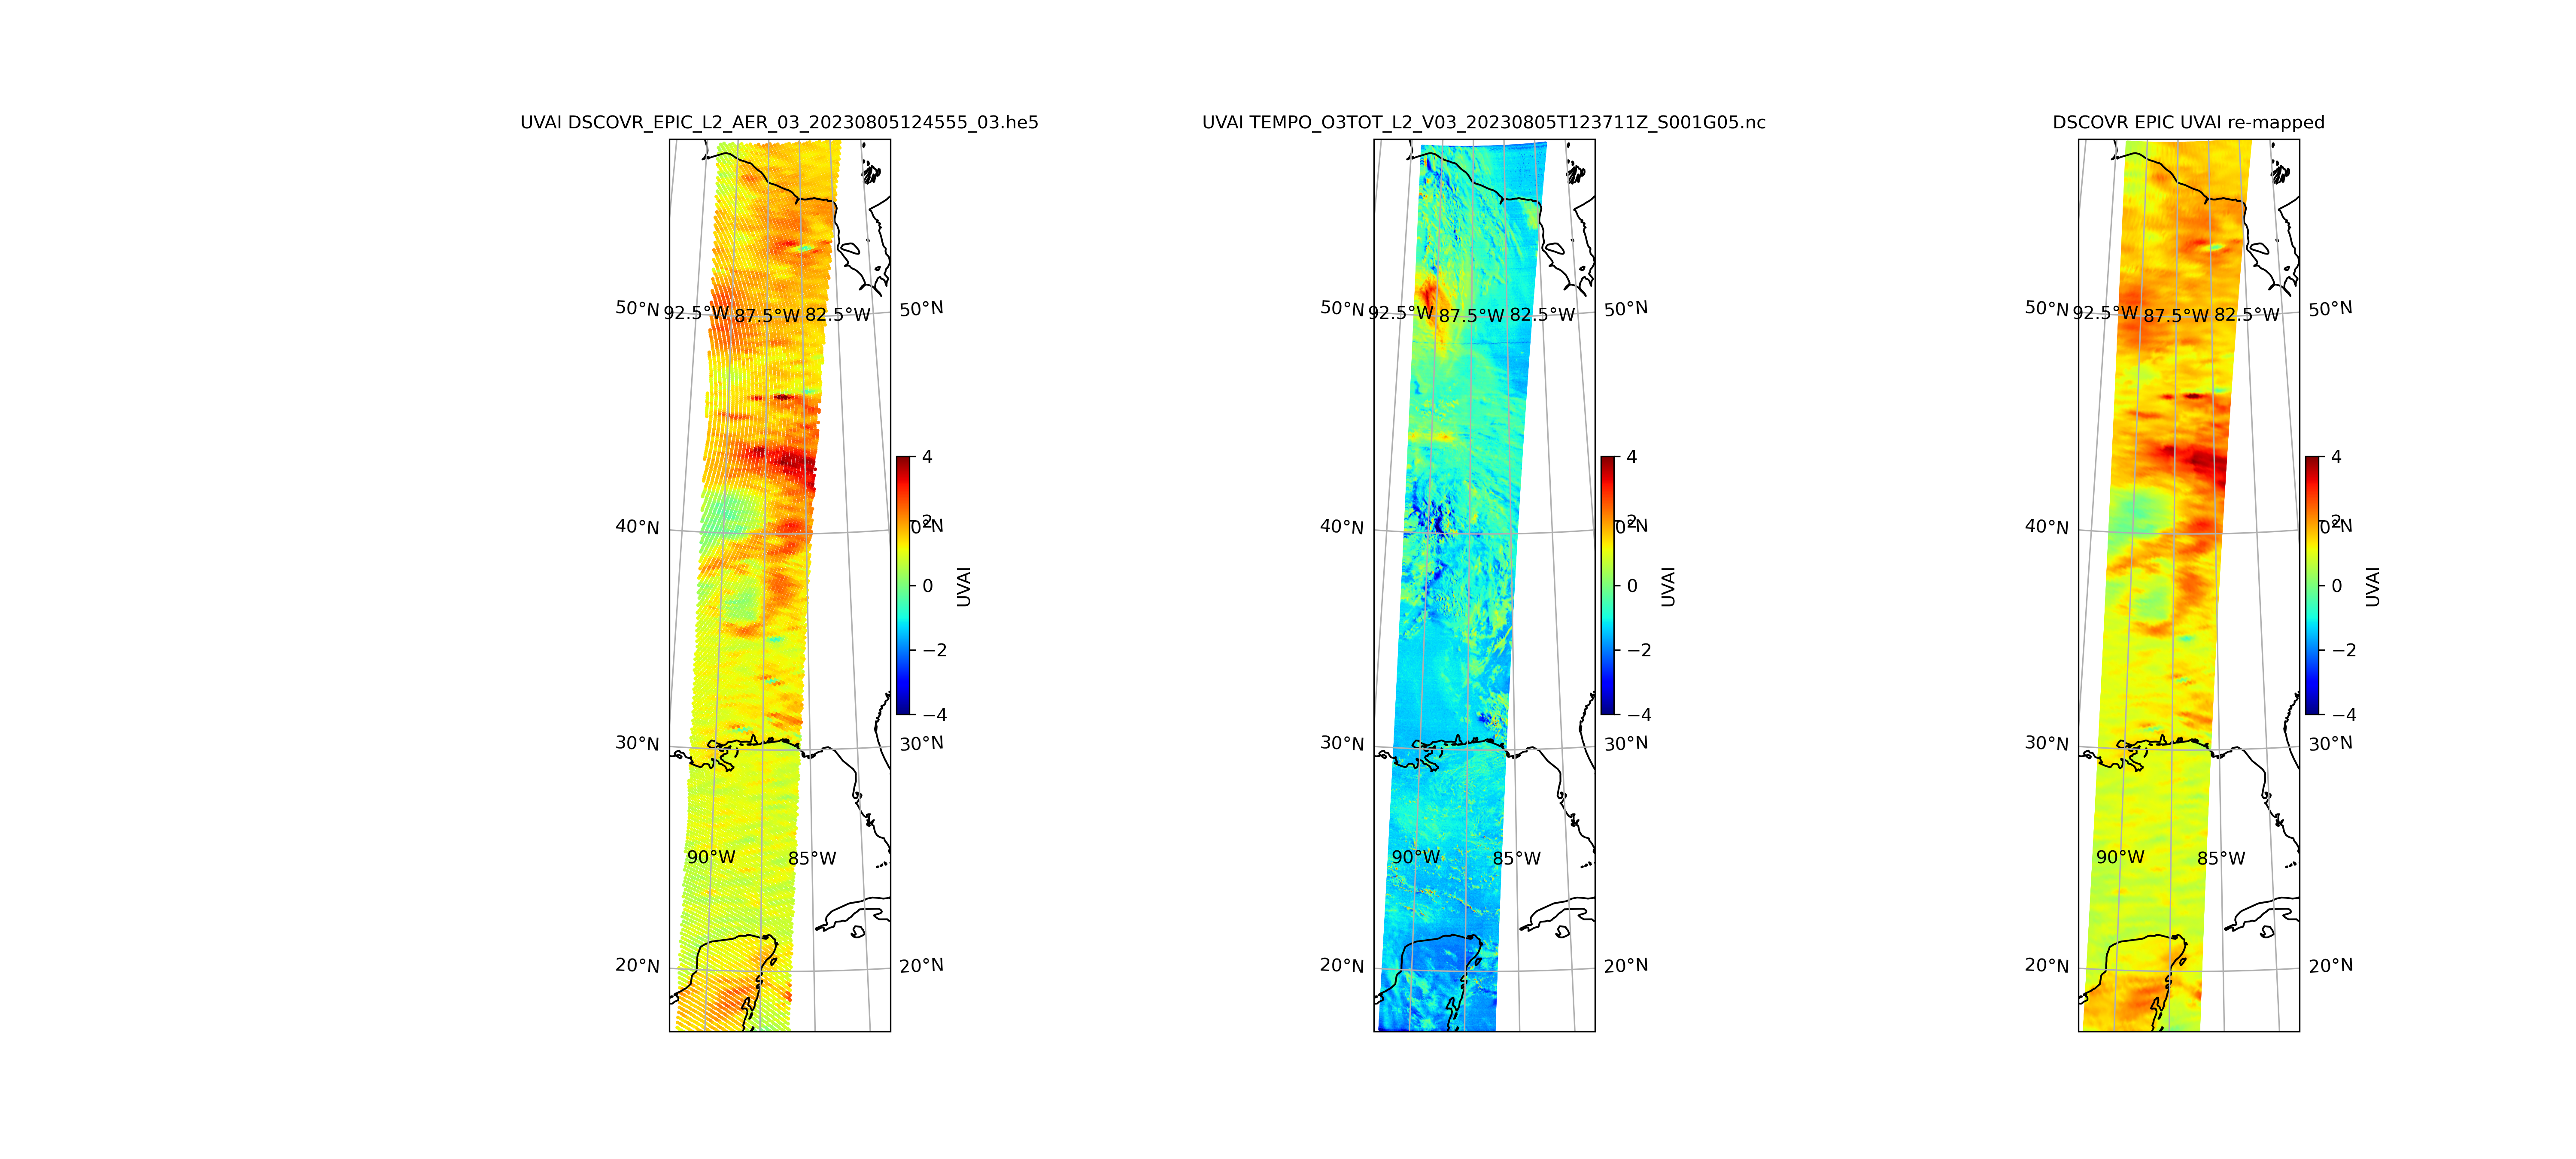